# Dependencies loading

In [816]:
import pandas as pd
import numpy as np
import seaborn as sns # Data Visualization
import matplotlib.pyplot as plt # Data Visualization
from matplotlib.ticker import FuncFormatter, LogLocator # Data Visualization
import plotly.express as px # Data Visualization
import statsmodels.api as sm # Statistics
import statsmodels.tsa.api as tsa # Statistics
from scipy.stats import norm, skew, kurtosis # Statistics
from scipy.optimize import minimize # Statistics
from pandas_datareader import data as pdr #import data from FRED
from datetime import datetime # Date and Time
from arch import arch_model # TS
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [788]:
import warnings
warnings.filterwarnings("ignore")

# Data preparation

## Data loading

In [789]:
BTC_url = 'https://raw.githubusercontent.com/IlyaSshnip/RR_project/main/Bitcoin_daily.csv'
SP500_url = 'https://raw.githubusercontent.com/IlyaSshnip/RR_project/main/S&P500.csv'
TMUBMUSD01Y_url = 'https://raw.githubusercontent.com/IlyaSshnip/RR_project/main/TMUBMUSD01Y.csv'

df_BTC = pd.read_csv(BTC_url)
df_BTC.columns = df_BTC.columns.str.strip()

df_SP500 = pd.read_csv(SP500_url)
df_SP500.columns = df_SP500.columns.str.strip()

df_TMUBMUSD01Y = pd.read_csv(TMUBMUSD01Y_url)
df_TMUBMUSD01Y.columns = df_TMUBMUSD01Y.columns.str.strip()

start=datetime(2014, 5, 1)
end=datetime(2024, 5, 1)

# Macroeconomic Indicators (from FRED):

UN_Rate = pdr.get_data_fred('UNRATE', start, end) # Unemployment Rate
Real_GDP = pdr.get_data_fred('A191RL1Q225SBEA', start, end) # Real GDP
CPI = pdr.get_data_fred('CPIAUCSL', start, end) # Consumer Price Index
VIX = pdr.get_data_fred('VIXCLS', start, end) # Volatility Index
Ten_Year_Treasury_Yield = pdr.get_data_fred('DGS10', start, end) # 10-Year Treasury Yield
Federal_Funds_Rate = pdr.get_data_fred('FEDFUNDS', start, end) # Federal Funds Rate
BBB_Credit_Spread = pdr.get_data_fred('BAMLC0A4CBBB', start, end) # BBB Credit Spread

# print(df_BTC.head())
# print(df_SP500.head())
# print(df_TMUBMUSD01Y.head())
# print(UN_Rate.head())
# print(Real_GDP.head())
# print(CPI.head())
# print(VIX.head())
# print(Ten_Year_Treasury_Yield.head())
# print(Federal_Funds_Rate.head())
# print(BBB_Credit_Spread.head())

## Dataset adjustment

In [790]:
# Select Columns
df_SP500 = df_SP500[['Date', 'Close']].rename(columns={'Close': 'Price'})
df_BTC = df_Bitcoin[['Date', 'Price']]
df_TMUBMUSD01Y = df_TMUBMUSD01Y[['Date', 'Close']].rename(columns={'Close': 'Price'})

########################################################################################

# Define Price as 'numeric'

df_SP500['Price'] = df_SP500['Price'].astype(str)
df_BTC['Price'] = df_BTC['Price'].astype(str)
df_TMUBMUSD01Y['Price'] = df_TMUBMUSD01Y['Price'].astype(str)

df_SP500['Price'] = pd.to_numeric(df_SP500['Price'].str.replace(',', ''), errors='coerce')
df_BTC['Price'] = pd.to_numeric(df_BTC['Price'].str.replace(',', ''), errors='coerce')
df_TMUBMUSD01Y['Price'] = pd.to_numeric(df_TMUBMUSD01Y['Price'].str.replace(',', ''), errors='coerce')

########################################################################################

# Date
df_SP500['Date'] = pd.to_datetime(df_SP500['Date'])
df_SP500.set_index('Date', inplace=True)

df_BTC['Date'] = pd.to_datetime(df_Bitcoin['Date'])
df_BTC.set_index('Date', inplace=True)

df_TMUBMUSD01Y['Date'] = pd.to_datetime(df_TMUBMUSD01Y['Date'])
df_TMUBMUSD01Y.set_index('Date', inplace=True)

# Sort by Date
df_SP500.sort_index(inplace=True)
df_BTC.sort_index(inplace=True)
df_TMUBMUSD01Y.sort_index(inplace=True)

df_SP500 = df_SP500.loc[start_date:end_date]
df_BTC = df_BTC.loc[start_date:end_date] # Cryptocurrency market is open on weekends
df_TMUBMUSD01Y = df_TMUBMUSD01Y.loc[start_date:end_date]

########################################################################################

# print(df_SP500.head())
# print(df_SP500.tail()) 
# print(df_TMUBMUSD01Y.head())
# print(df_TMUBMUSD01Y.tail())
# print(df_BTC.tail())

## Returns calculation (Daily)

In [791]:
df_SP500['Return'] = df_SP500['Price'].pct_change() 
df_BTC['Return'] = df_BTC['Price'].pct_change() 
df_TMUBMUSD01Y['Return'] = df_TMUBMUSD01Y['Price'].pct_change() 

## Cumulative Returns calculation

In [792]:
# print(df_SP500.head())
# print(df_TMUBMUSD01Y.head())
# print(df_BTC.head())

# Exploratory Data Analysis

## Summary Statistics

In [793]:
print(df_SP500.describe())
print(df_BTC.describe())
print(df_TMUBMUSD01Y.describe())

             Price       Return
count  2517.000000  2516.000000
mean   3110.347695     0.000454
std     944.565837     0.011169
min    1829.079956    -0.119841
25%    2180.389893    -0.003781
50%    2859.530029     0.000596
75%    3992.929932     0.005679
max    5254.350098     0.093828
              Price       Return
count   3653.000000  3652.000000
mean   15429.602245     0.002026
std    17681.737231     0.036928
min      164.900000    -0.391816
25%      704.300000    -0.012350
50%     8184.900000     0.001215
75%    26249.800000     0.017040
max    73066.300000     0.272286
             Price       Return
count  2535.000000  2534.000000
mean      1.657550     0.013132
std       1.699658     0.389896
min       0.005000    -0.934211
25%       0.214000    -0.011442
50%       1.068000     0.000000
75%       2.450000     0.012883
max       5.515000    14.200000


## Check for Missing Values

In [794]:
print(df_SP500.isnull().sum())
print(df_BTC.isnull().sum())
print(df_TMUBMUSD01Y.isnull().sum())

Price     0
Return    1
dtype: int64
Price     0
Return    1
dtype: int64
Price     0
Return    1
dtype: int64


## Price Changes of the S&P 500 Index, Bitcoin, and the 1-Year U.S. Treasury Bond

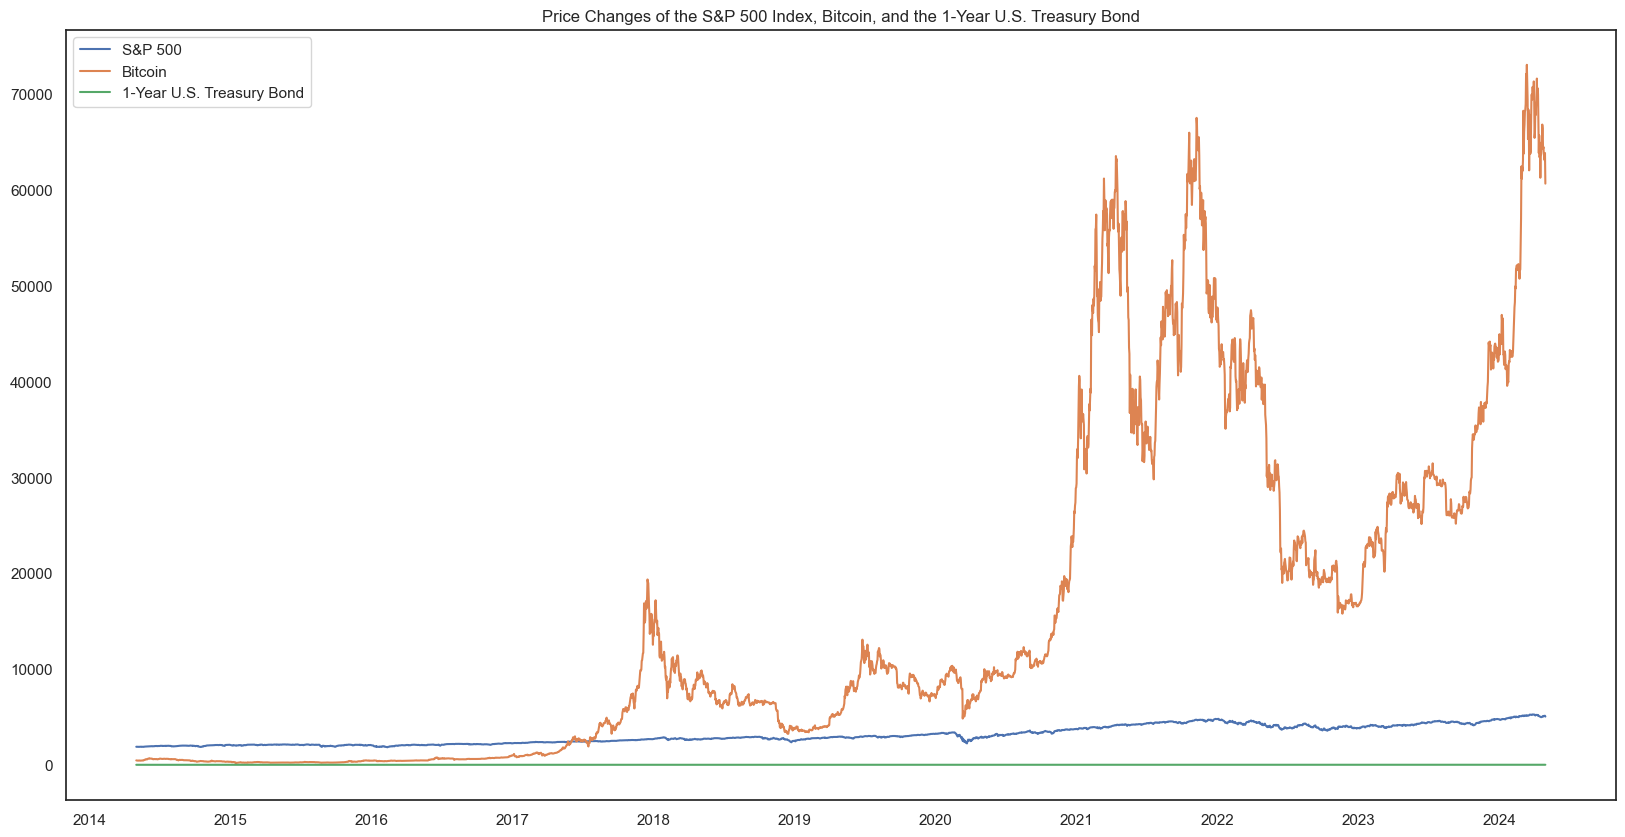

In [795]:
plt.figure(figsize=(20, 10))

plt.plot(df_SP500.index, df_SP500['Price'], label='S&P 500')
plt.plot(df_BTC.index, df_BTC['Price'], label='Bitcoin')
plt.plot(df_TMUBMUSD01Y.index, df_TMUBMUSD01Y['Price'], label='1-Year U.S. Treasury Bond')

plt.xlabel('')
plt.ylabel('')
plt.title('Price Changes of the S&P 500 Index, Bitcoin, and the 1-Year U.S. Treasury Bond')
plt.legend()
plt.show()

### S&P 500 Index

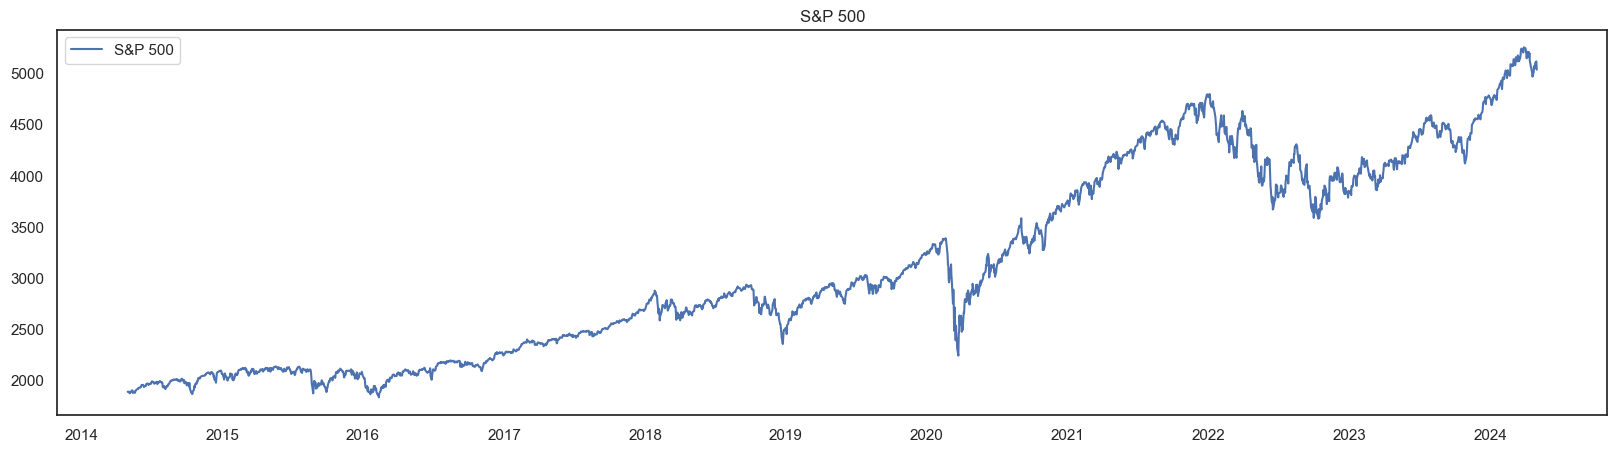

In [796]:
plt.figure(figsize=(20, 5))
plt.plot(df_SP500.index, df_SP500['Price'], label='S&P 500')
plt.xlabel('')
plt.ylabel('')
plt.title('S&P 500')
plt.legend()
plt.grid(False)
plt.show()

### Bitcoin

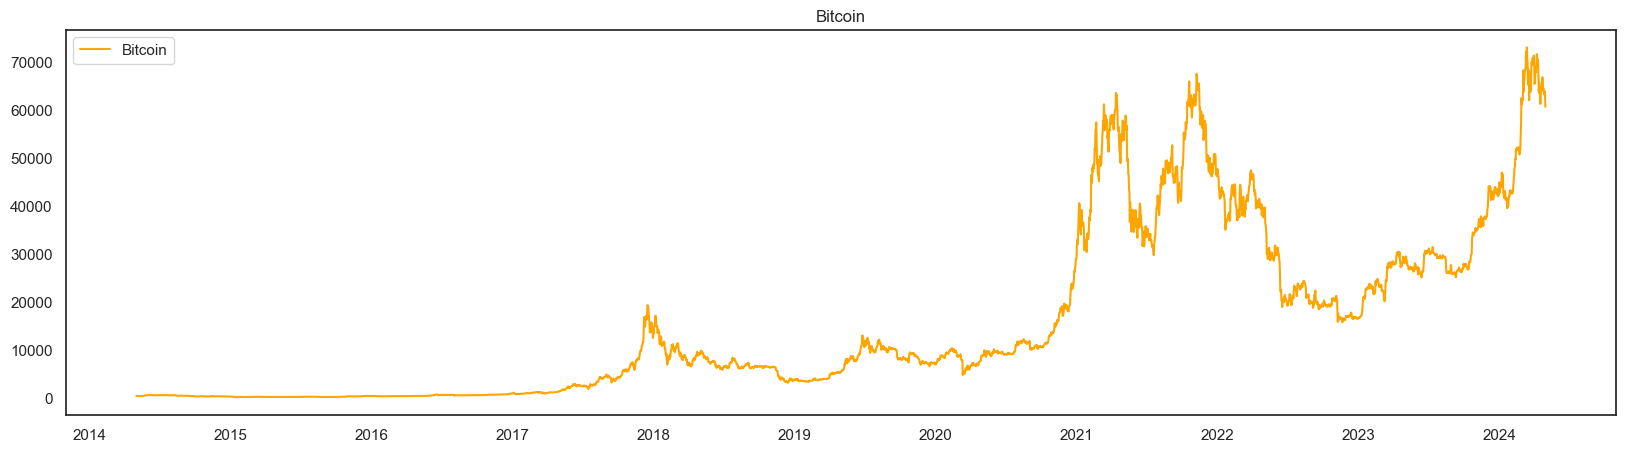

In [797]:
plt.figure(figsize=(20, 5))
plt.plot(df_BTC.index, df_BTC['Price'], label='Bitcoin', color='orange')
plt.xlabel('')
plt.ylabel('')
plt.title('Bitcoin')
plt.legend()
plt.grid(False)
plt.show()

### 1-Year U.S. Treasury Bond

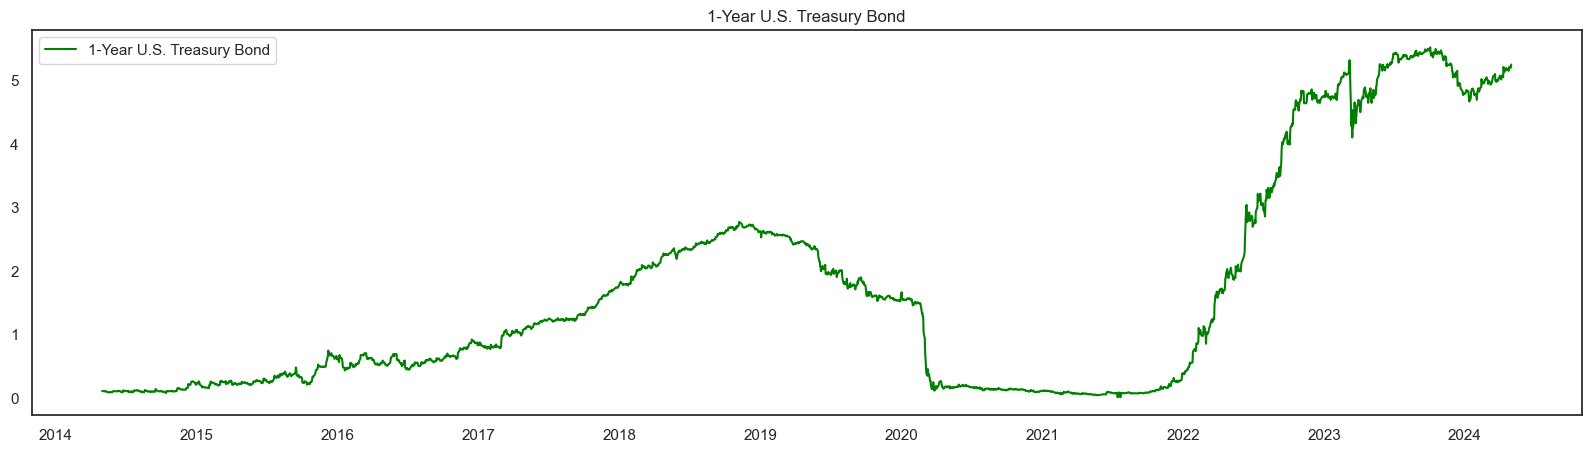

In [798]:
plt.figure(figsize=(20, 5))
plt.plot(df_TMUBMUSD01Y.index, df_TMUBMUSD01Y['Price'], label='1-Year U.S. Treasury Bond', color='green')
plt.xlabel('')
plt.ylabel('')
plt.title('1-Year U.S. Treasury Bond')
plt.legend()
plt.grid(False)
plt.show()

## Daily Returns

In [799]:
df_combined_returns = pd.concat([df_SP500[['Return']], df_BTC[['Return']], df_TMUBMUSD01Y[['Return']]], axis=1, join='inner')
df_combined_returns.columns = ['SP500_Return', 'BTC_Return', 'TMUBMUSD01Y_Return']

In [800]:
df_combined_returns

,SP500_Return,BTC_Return,TMUBMUSD01Y_Return
Date,,,
2014-05-01,NaN,NaN,NaN
2014-05-02,-0.001348,-0.013910,0.000000
2014-05-05,0.001871,-0.011697,-0.019231
2014-05-06,-0.008988,0.003017,0.000000
2014-05-07,0.005616,0.033087,-0.029412
...,...,...,...
2024-04-24,0.000213,-0.032061,0.001944
2024-04-25,-0.004576,0.003288,0.010475
2024-04-26,0.010209,-0.011329,-0.002496


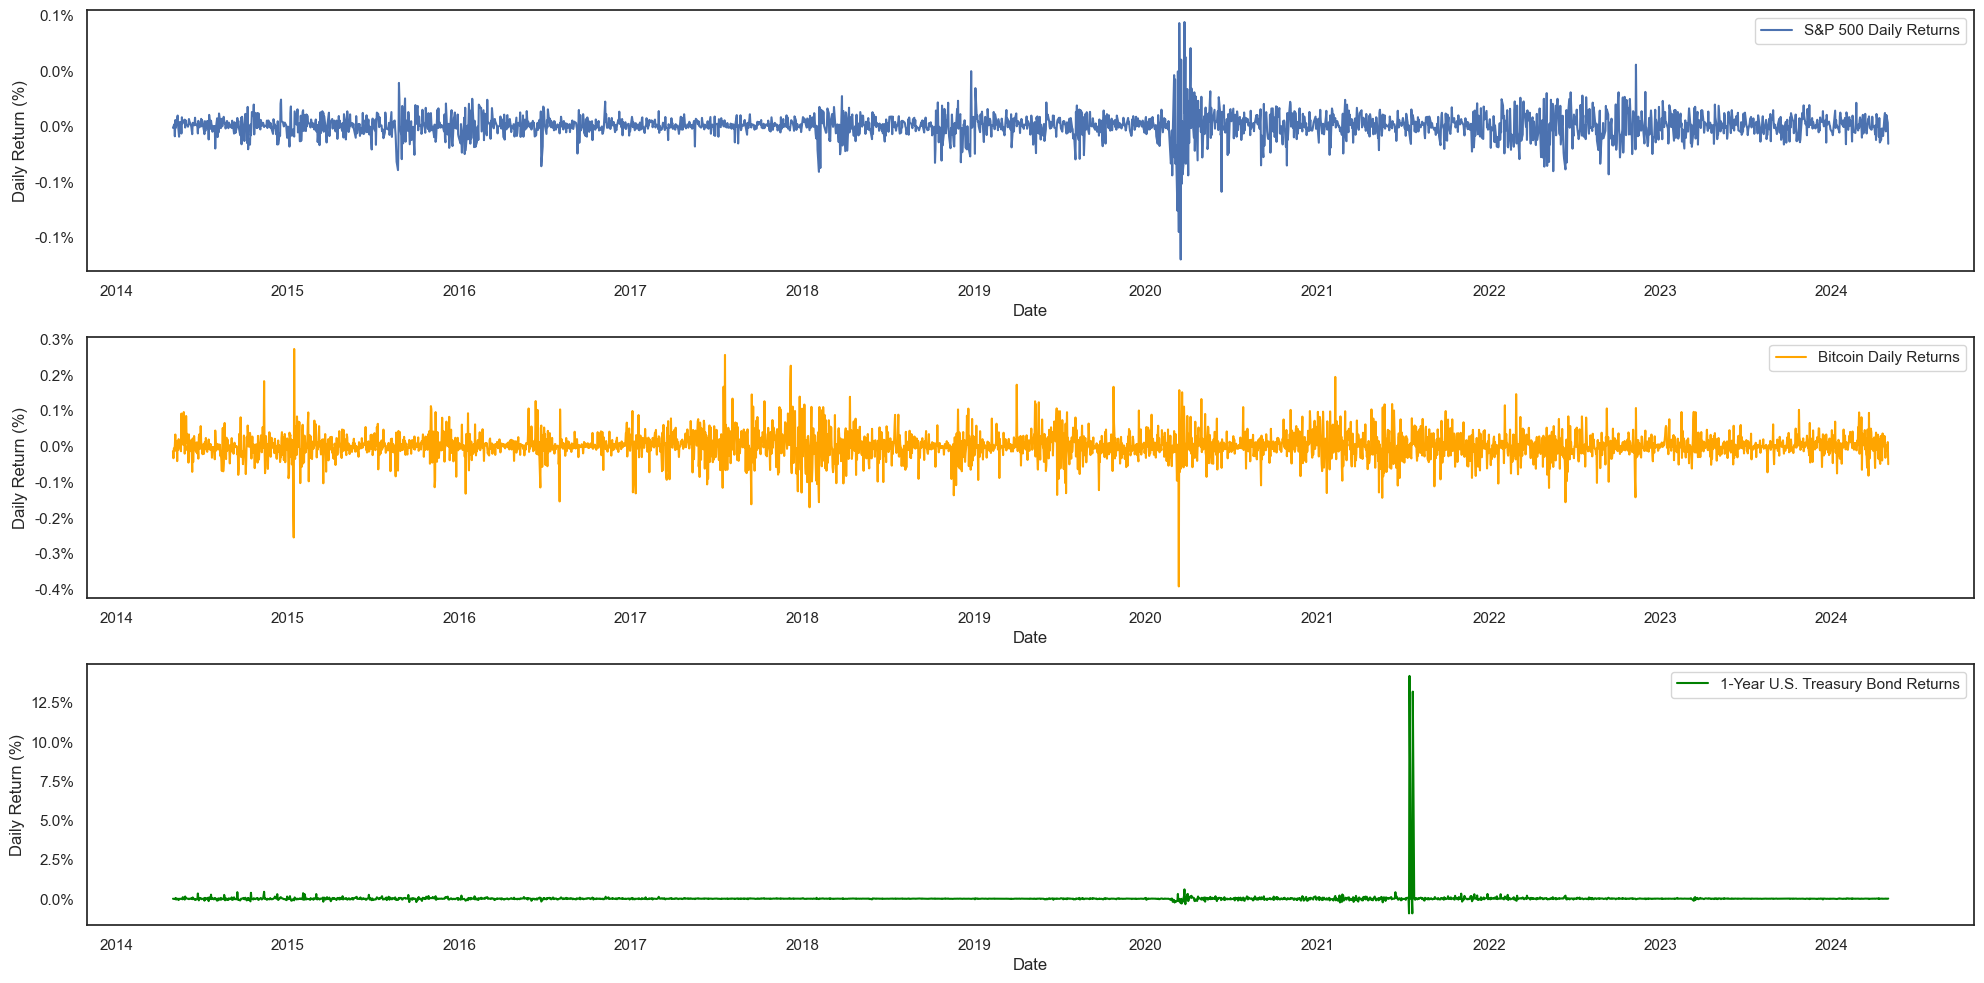

In [801]:
def percentage_formatter(x, pos):
    return f'{x:.1f}%'

plt.figure(figsize=(20, 10))

plt.subplot(3, 1, 1)
plt.plot(df_SP500.index, df_SP500['Return'], label='S&P 500 Daily Returns')
plt.title('')
plt.xlabel('Date')
plt.ylabel('Daily Return (%)')
plt.gca().yaxis.set_major_formatter(FuncFormatter(percentage_formatter))
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(df_BTC.index, df_BTC['Return'], label='Bitcoin Daily Returns', color='orange')
plt.title('')
plt.xlabel('Date')
plt.ylabel('Daily Return (%)')
plt.gca().yaxis.set_major_formatter(FuncFormatter(percentage_formatter))
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(df_TMUBMUSD01Y.index, df_TMUBMUSD01Y['Return'], label='1-Year U.S. Treasury Bond Returns', color='green')
plt.title('')
plt.xlabel('Date')
plt.ylabel('Daily Return (%)')
plt.gca().yaxis.set_major_formatter(FuncFormatter(percentage_formatter))
plt.legend()

plt.tight_layout()
plt.show()

### Correlation

In [802]:
""" Forward-filling missing values ensures consistency gaps 
by filling gaps with the last available observation, which is essential 
when aligning datasets with different trading schedules
, such as traditional markets and Bitcoin (Open on Weekends)."""

# This piece of code was taken from ChapGPT 
# Recommended using Forward-filling for Bitcoin

df_SP500 = df_SP500.asfreq('D').fillna(method='ffill')
df_TMUBMUSD01Y = df_TMUBMUSD01Y.asfreq('D').fillna(method='ffill')

# Merge files & Rename Columns
df_assets = pd.merge(df_SP500, df_BTC, on='Date', how='outer')
df_assets = pd.merge(df_assets, df_TMUBMUSD01Y, on='Date', how='outer')

df_assets.columns = ['SP500_Price', 'SP500_Return', 'BTC_Price', 'BTC_Return', 'TMUBMUSD01Y_Price', 'TMUBMUSD01Y_Return']

# Drop NaN
df_assets.dropna(subset=['SP500_Return', 'BTC_Return', 'TMUBMUSD01Y_Return'], inplace=True)

# print(df_assets.head())

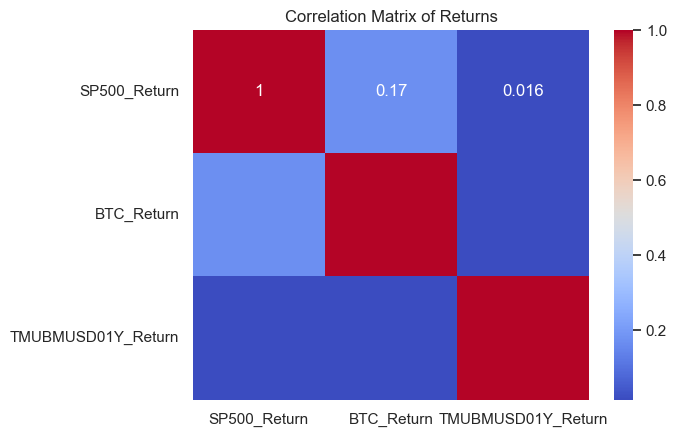

In [803]:
correlation_matrix = df_assets[['SP500_Return', 'BTC_Return', 'TMUBMUSD01Y_Return']].corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Returns')
plt.show()

The correlation matrix shows that S&P 500 and Bitcoin returns have a weak positive correlation (0.17), while both have minimal correlation with 1-Year U.S. Treasury returns.

## Statistical Analysis

### Summary

In [809]:
print(df_combined_returns.describe())

       SP500_Return   BTC_Return  TMUBMUSD01Y_Return
count   2500.000000  2500.000000         2500.000000
mean       0.000462     0.002399            0.013386
std        0.011183     0.039886            0.392496
min       -0.119841    -0.391816           -0.934211
25%       -0.003789    -0.013977           -0.011549
50%        0.000600     0.001383            0.000000
75%        0.005692     0.019091            0.013143
max        0.093828     0.272286           14.200000


In [807]:
print(df_combined_returns.skew())

SP500_Return          -0.518575
BTC_Return            -0.129652
TMUBMUSD01Y_Return    34.090014
dtype: float64


In [808]:
print(df_combined_returns.kurtosis())

SP500_Return            14.934157
BTC_Return               8.516432
TMUBMUSD01Y_Return    1192.704632
dtype: float64


### ADF

In [823]:
def adf_test(series):
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] <= 0.05:
        print("Reject the null hypothesis - stationary")
    else:
        print("Fail to reject the null hypothesis - non-stationary")

adf_test(df_combined_returns['SP500_Return'])
adf_test(df_combined_returns['BTC_Return'])
adf_test(df_combined_returns['TMUBMUSD01Y_Return'])

ADF Statistic: -15.696102760271707
p-value: 1.4145081703855867e-28
Reject the null hypothesis - stationary
ADF Statistic: -27.879839702337545
p-value: 0.0
Reject the null hypothesis - stationary
ADF Statistic: -8.657891314817109
p-value: 4.9121247555259015e-14
Reject the null hypothesis - stationary


We reject the null hypothesis, concluding that the data is stationary.

### KDE

The KDE plots show that the distributions of S&P 500 and Bitcoin returns are centered around zero with heavy tails, suggesting high volatility. In contrast, the 1-Year U.S. Treasury Bond returns display positive skew with extreme values.

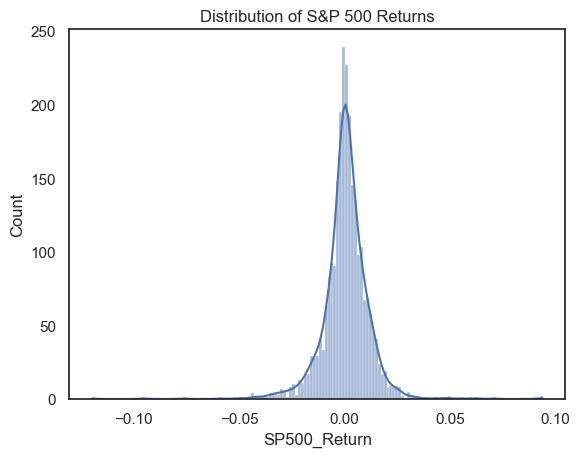

In [811]:
sns.histplot(df_combined_returns['SP500_Return'], kde=True)
plt.title('Distribution of S&P 500 Returns')
plt.show()

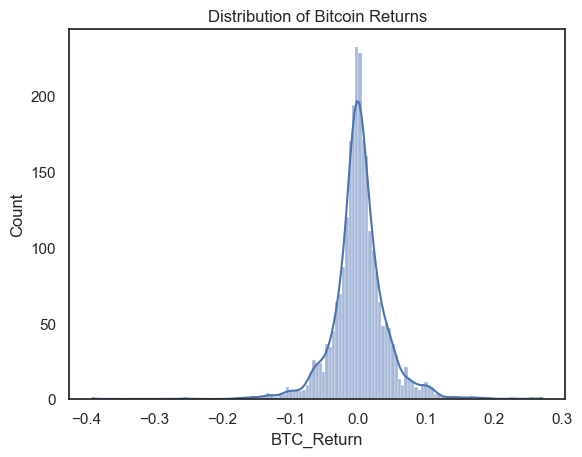

In [813]:
sns.histplot(df_combined_returns['BTC_Return'], kde=True)
plt.title('Distribution of Bitcoin Returns')
plt.show()

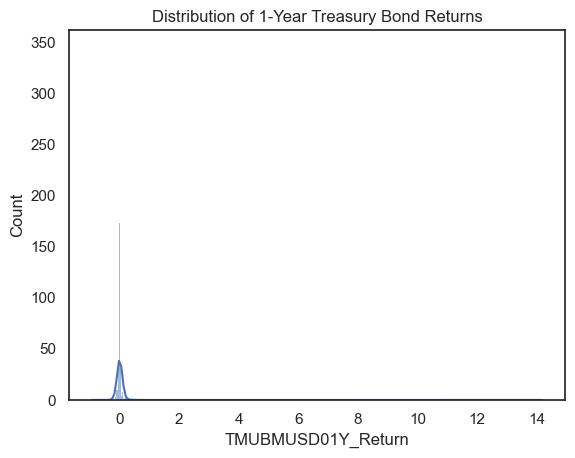

In [814]:
sns.histplot(df_combined_returns['TMUBMUSD01Y_Return'], kde=True)
plt.title('Distribution of 1-Year Treasury Bond Returns')
plt.show()

### Plots

The box plots reveal that both the S&P 500 and Bitcoin returns have numerous outliers, indicating extreme values, while the 1-Year U.S. Treasury Bond returns exhibit significant positive outliers. 

These findings suggest the need to investigate whether these extreme values are associated with specific market events.

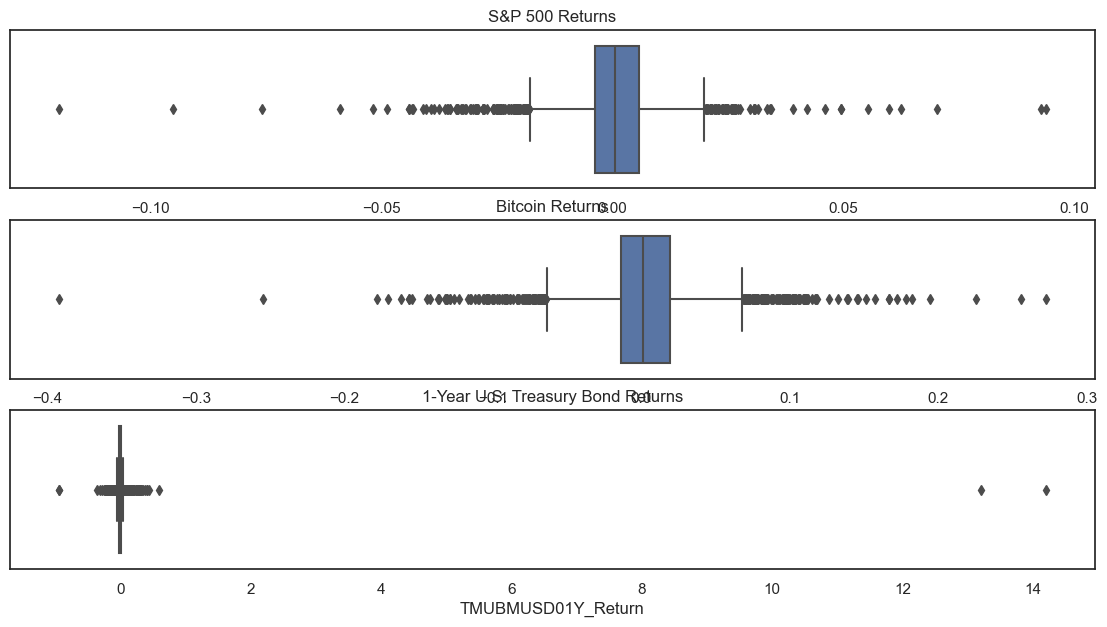

In [827]:
plt.figure(figsize=(14, 7))

plt.subplot(3, 1, 1)
sns.boxplot(x=df_combined_returns['SP500_Return'])
plt.title('S&P 500 Returns')



plt.subplot(3, 1, 3)
sns.boxplot(x=df_combined_returns['TMUBMUSD01Y_Return'])
plt.title('1-Year U.S. Treasury Bond Returns')

plt.show()

### Outliers

In [900]:
def extreme_values(df, column, percentile=0.01):
    threshold_high = df[column].quantile(1 - percentile)
    threshold_low = df[column].quantile(percentile)
    high = df[df[column] >= threshold_high]
    low = df[df[column] <= threshold_low]
    return high, low

In [899]:
high_sp500, low_sp500 = extreme_values(df_combined_returns, 'SP500_Return')
high_btc, low_btc = extreme_values(df_combined_returns, 'BTC_Return')
high_treasury, low_treasury = extreme_values(df_combined_returns, 'TMUBMUSD01Y_Return')

In [898]:
extreme_sp500_dates = high_sp500.index.union(low_sp500.index)
print(extreme_sp500_dates)

DatetimeIndex(['2020-01-31', '2020-04-19', '2020-05-16', '2020-07-26',
               '2020-08-04', '2020-08-22', '2020-11-01', '2021-03-21',
               '2021-03-26', '2021-04-21', '2021-05-20', '2021-05-24',
               '2021-07-28', '2021-09-18', '2021-10-04', '2021-12-20',
               '2021-12-21', '2022-01-19', '2022-08-28', '2022-09-02'],
              dtype='datetime64[ns]', name='Date', freq=None)


In [897]:
extreme_btc_dates = high_btc.index.union(low_btc.index)
print(extreme_btc_dates)

DatetimeIndex(['2020-01-13', '2020-04-20', '2020-08-28', '2020-09-19',
               '2020-10-17', '2020-11-13', '2021-01-03', '2021-01-15',
               '2021-01-30', '2021-06-14', '2021-06-27', '2021-07-17',
               '2021-12-12', '2022-01-27', '2022-02-13', '2022-03-22',
               '2022-04-01', '2022-07-04', '2022-08-28', '2022-09-11'],
              dtype='datetime64[ns]', name='Date', freq=None)


In [896]:
extreme_treasury_dates = high_treasury.index.union(low_treasury.index)
print(extreme_treasury_dates)

DatetimeIndex(['2020-02-09', '2020-03-31', '2020-04-06', '2020-05-22',
               '2020-06-07', '2020-06-23', '2020-08-10', '2020-09-11',
               '2020-11-23', '2020-12-13', '2021-03-03', '2021-04-18',
               '2021-09-29', '2022-02-26', '2022-03-04', '2022-04-21',
               '2022-05-26', '2022-06-21', '2022-08-20', '2022-08-23'],
              dtype='datetime64[ns]', name='Date', freq=None)


### Conclusion

COVID-19 pandemic was the major driver of extreme market movements across these different asset classes.

## Rolling Statistics

#### Calculate and plot rolling std for all portfolios with 21-day window

In [804]:
# Reference: Portfolio_Performance repository
# File: whale_analysis.ipynb
# URL: https://github.com/lrb924/Portfolio_Performance/blob/main/whale_analysis.ipynb

window = 21

df_assets['SP500_Rolling_Mean'] = df_assets['SP500_Return'].rolling(window).mean()
df_assets['SP500_Rolling_Std'] = df_assets['SP500_Return'].rolling(window).std()

df_assets['BTC_Rolling_Mean'] = df_assets['BTC_Return'].rolling(window).mean()
df_assets['BTC_Rolling_Std'] = df_assets['BTC_Return'].rolling(window).std()

df_assets['TMUBMUSD01Y_Rolling_Mean'] = df_assets['TMUBMUSD01Y_Return'].rolling(window).mean()
df_assets['TMUBMUSD01Y_Rolling_Std'] = df_assets['TMUBMUSD01Y_Return'].rolling(window).std()

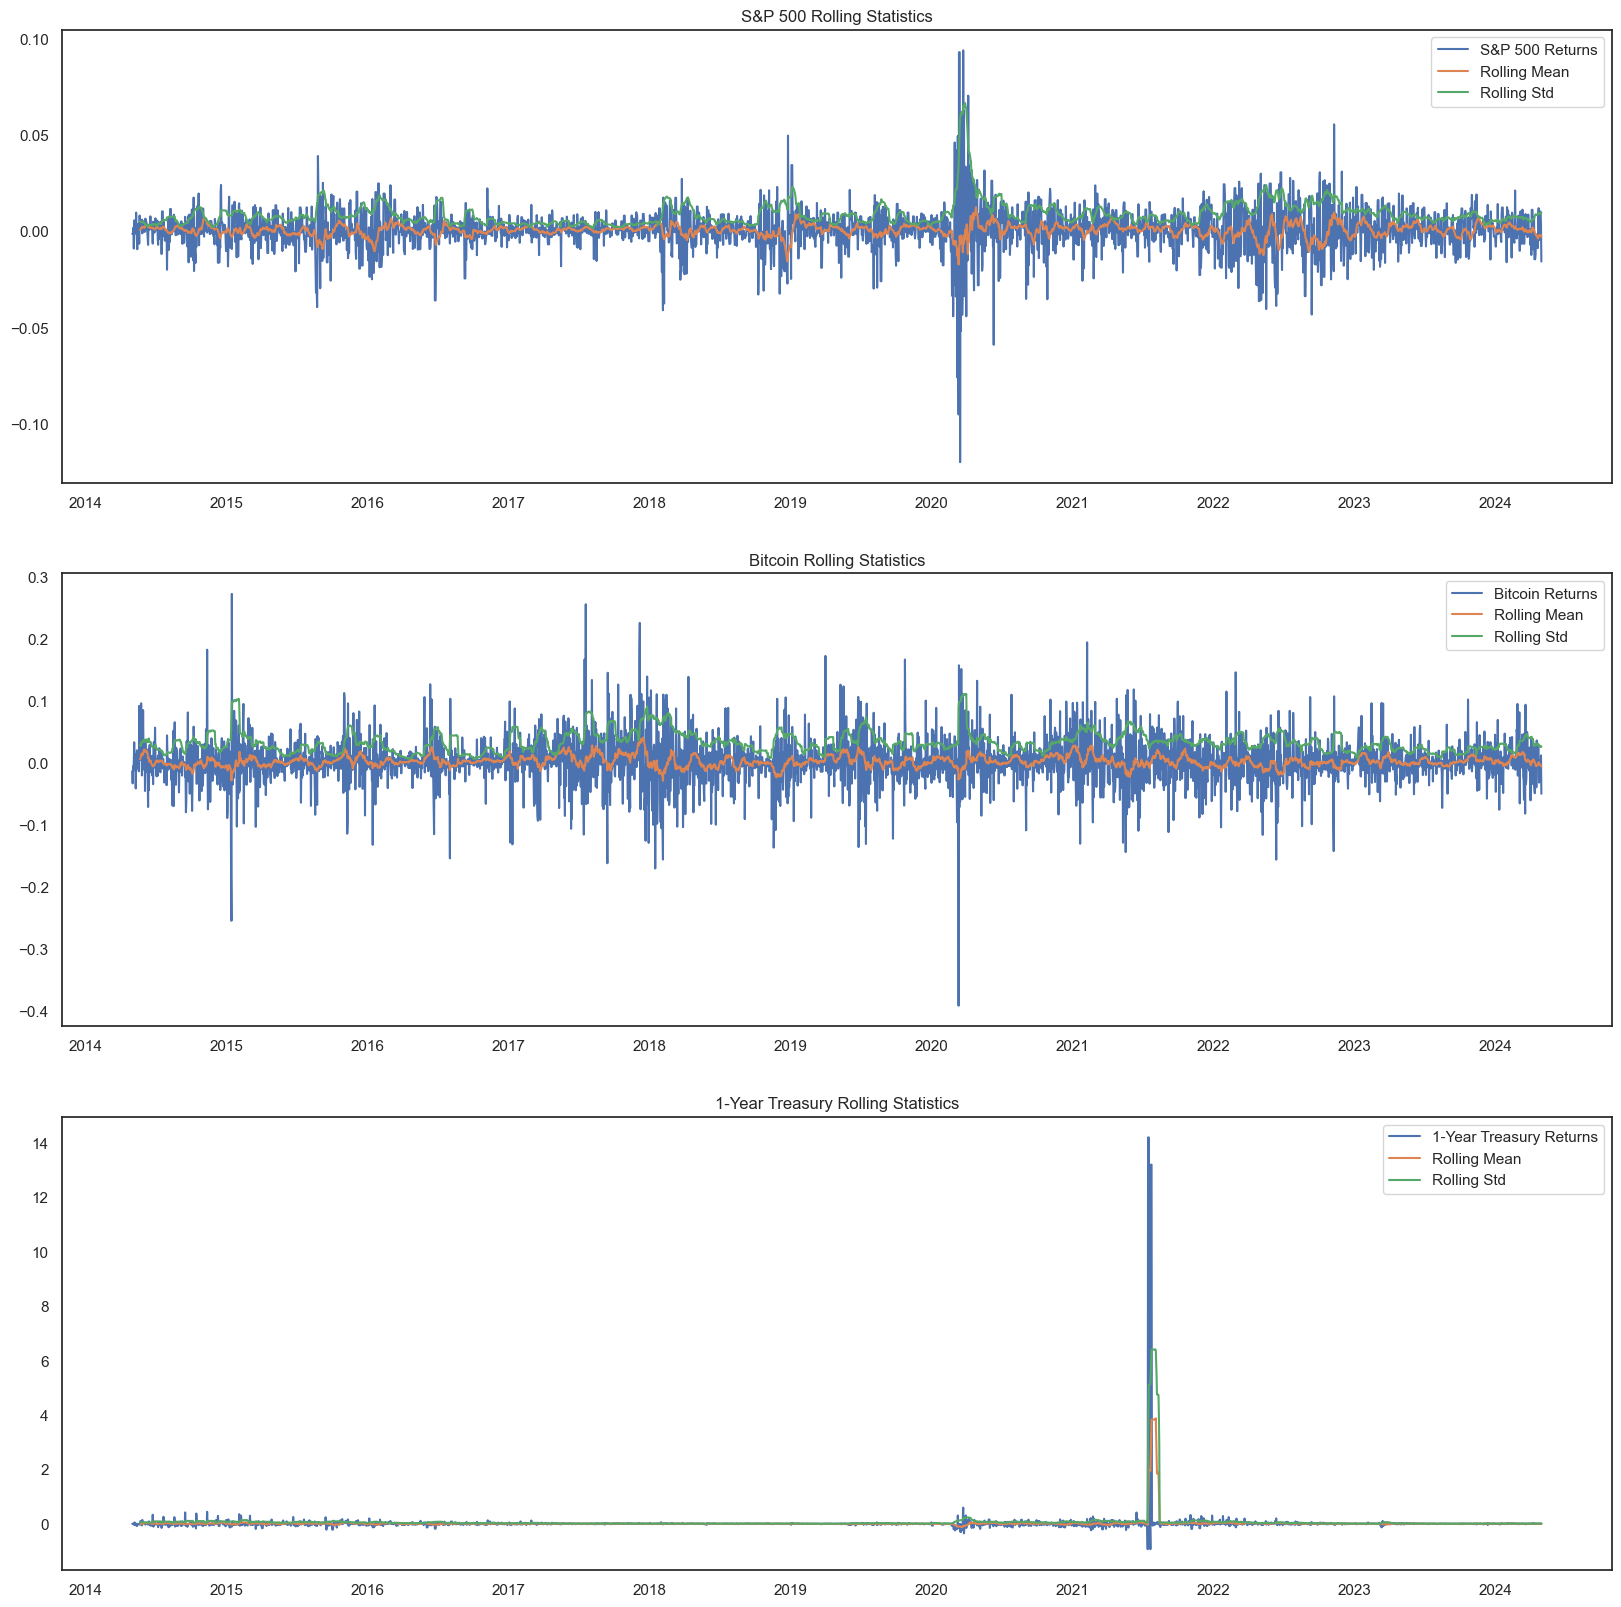

In [805]:
plt.figure(figsize=(20, 20))

plt.subplot(3, 1, 1)
plt.plot(df_assets.index, df_assets['SP500_Return'], label='S&P 500 Returns')
plt.plot(df_assets.index, df_assets['SP500_Rolling_Mean'], label='Rolling Mean')
plt.plot(df_assets.index, df_assets['SP500_Rolling_Std'], label='Rolling Std')
plt.title('S&P 500 Rolling Statistics')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(df_assets.index, df_assets['BTC_Return'], label='Bitcoin Returns')
plt.plot(df_assets.index, df_assets['BTC_Rolling_Mean'], label='Rolling Mean')
plt.plot(df_assets.index, df_assets['BTC_Rolling_Std'], label='Rolling Std')
plt.title('Bitcoin Rolling Statistics')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(df_assets.index, df_assets['TMUBMUSD01Y_Return'], label='1-Year Treasury Returns')
plt.plot(df_assets.index, df_assets['TMUBMUSD01Y_Rolling_Mean'], label='Rolling Mean')
plt.plot(df_assets.index, df_assets['TMUBMUSD01Y_Rolling_Std'], label='Rolling Std')
plt.title('1-Year Treasury Rolling Statistics')
plt.legend()

plt.show()

- S&P 500: The average returns are stable, but volatility spiked during the COVID-19 pandemic in early 2020, indicating increased market uncertainty.

- Bitcoin: Returns are more volatile than the S&P 500, with several large spikes, showing higher risk and instability, especially during economic events.

- 1-Year Treasury Bond: Typically very stable with low volatility, except for a sharp increase during the COVID-19 pandemic, reflecting its role as a safe-haven asset.

## ACF & PACF

<Figure size 1200x600 with 0 Axes>

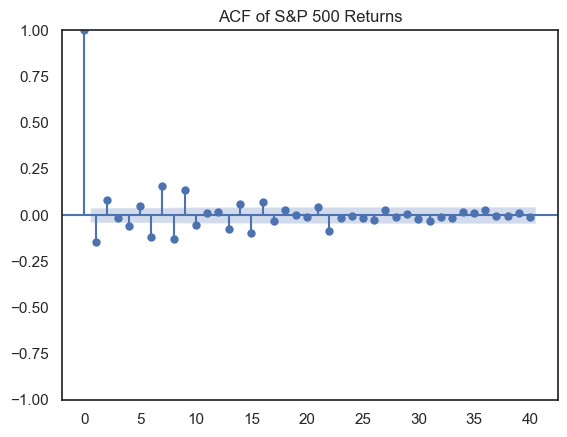

<Figure size 1200x600 with 0 Axes>

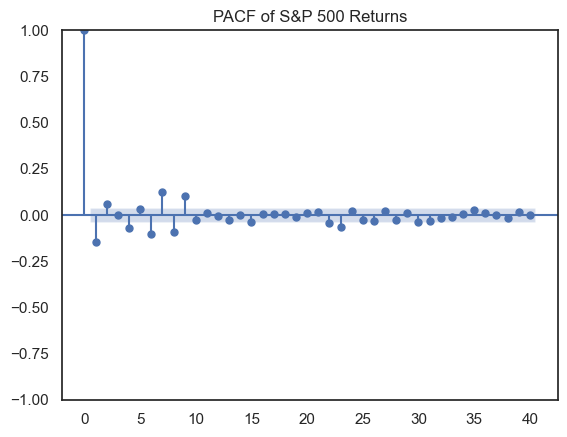

In [821]:
plt.figure(figsize=(12, 6))
plot_acf(df_combined_returns['SP500_Return'].dropna(), lags=40)
plt.title('ACF of S&P 500 Returns')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(df_combined_returns['SP500_Return'].dropna(), lags=40)
plt.title('PACF of S&P 500 Returns')
plt.show()

<Figure size 1200x600 with 0 Axes>

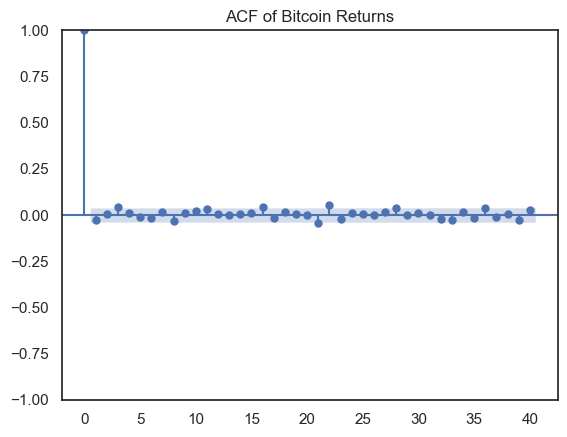

<Figure size 1200x600 with 0 Axes>

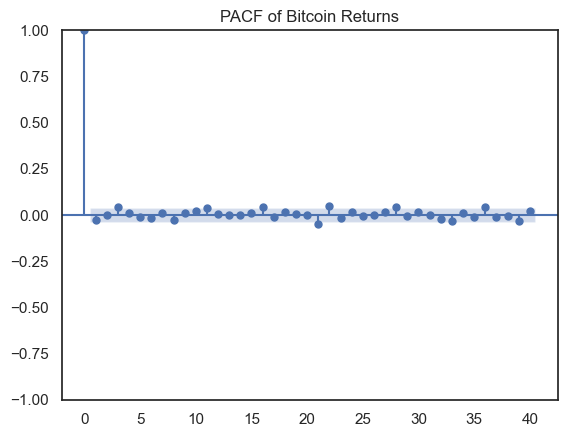

In [819]:
plt.figure(figsize=(12, 6))
plot_acf(df_combined_returns['BTC_Return'].dropna(), lags=40)
plt.title('ACF of Bitcoin Returns')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(df_combined_returns['BTC_Return'].dropna(), lags=40)
plt.title('PACF of Bitcoin Returns')
plt.show()

<Figure size 1200x600 with 0 Axes>

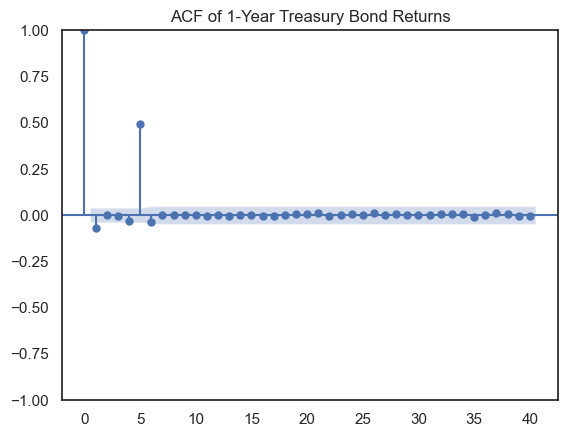

<Figure size 1200x600 with 0 Axes>

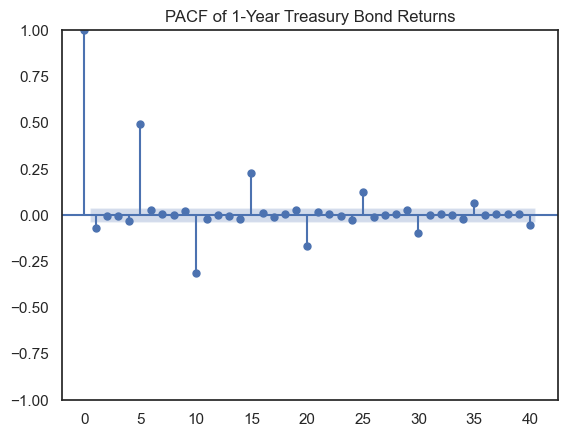

In [820]:
plt.figure(figsize=(12, 6))
plot_acf(df_combined_returns['TMUBMUSD01Y_Return'].dropna(), lags=40)
plt.title('ACF of 1-Year Treasury Bond Returns')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(df_combined_returns['TMUBMUSD01Y_Return'].dropna(), lags=40)
plt.title('PACF of 1-Year Treasury Bond Returns')
plt.show()